In [15]:
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np


In [16]:
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

In [19]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label,"completed")
    return image_paths, labels    

In [20]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

angry completed
disgust completed
fear completed
happy completed
neutral completed


In [21]:
print(train)


                                image    label
0            images/train\angry\0.jpg    angry
1            images/train\angry\1.jpg    angry
2           images/train\angry\10.jpg    angry
3        images/train\angry\10002.jpg    angry
4        images/train\angry\10016.jpg    angry
...                               ...      ...
17763  images/train\neutral\23313.jpg  neutral
17764  images/train\neutral\23317.jpg  neutral
17765   images/train\neutral\2334.jpg  neutral
17766  images/train\neutral\23344.jpg  neutral
17767  images/train\neutral\23356.jpg  neutral

[17768 rows x 2 columns]


In [22]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)


angry completed
disgust completed
fear completed
happy completed
neutral completed


In [24]:
print(test)
print(test['image'])

                               image    label
0            images/test\angry\0.jpg    angry
1            images/test\angry\1.jpg    angry
2           images/test\angry\10.jpg    angry
3        images/test\angry\10002.jpg    angry
4        images/test\angry\10016.jpg    angry
...                              ...      ...
17763  images/test\neutral\23313.jpg  neutral
17764  images/test\neutral\23317.jpg  neutral
17765   images/test\neutral\2334.jpg  neutral
17766  images/test\neutral\23344.jpg  neutral
17767  images/test\neutral\23356.jpg  neutral

[17768 rows x 2 columns]
0              images/test\angry\0.jpg
1              images/test\angry\1.jpg
2             images/test\angry\10.jpg
3          images/test\angry\10002.jpg
4          images/test\angry\10016.jpg
                     ...              
17763    images/test\neutral\23313.jpg
17764    images/test\neutral\23317.jpg
17765     images/test\neutral\2334.jpg
17766    images/test\neutral\23344.jpg
17767    images/test\neutral\233

In [27]:
from tqdm.notebook import tqdm

In [33]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,grayscale = True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features

In [34]:
train_features = extract_features(train['image'])

  0%|          | 0/17768 [00:00<?, ?it/s]

C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [35]:
test_features = extract_features(test['image'])

  0%|          | 0/17768 [00:00<?, ?it/s]

In [95]:
x_train = train_features/255.0
x_test = test_features/255.0

In [96]:
print("Original shape of y_train:", train['label'].shape)

Original shape of y_train: (17768,)


In [97]:
from sklearn.preprocessing import LabelEncoder

In [98]:
le = LabelEncoder()

In [99]:
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])

In [100]:
y_train = to_categorical(y_train, num_classes = 5)
y_test = to_categorical(y_test, num_classes = 5)

In [101]:
print("Shape of y_train after one-hot encoding:", y_train.shape)  # Should be (17768, 5)

Shape of y_train after one-hot encoding: (17768, 5)


In [102]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Fix the incorrect dropout parameter

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(5, activation='softmax'))

C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [103]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

In [105]:
model_json = model.to_json()
with open("emotiondetector.json",'w') as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")    

In [106]:
from keras.models import model_from_json

In [108]:
json_file = open("emotiondetector.json", 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("emotiondetector.h5")

In [110]:
label = ['angry', 'disgust', 'fear', 'happy', 'neutral']

In [114]:
def ef(image):
    img = load_img(image, grayscale = True)
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

In [115]:
image = 'images/train/angry/22.jpg'
print("original image is of angry")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
model prediction is  angry


In [120]:
import matplotlib.pyplot as plt
%matplotlib inline

original image of happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
model prediction is  happy


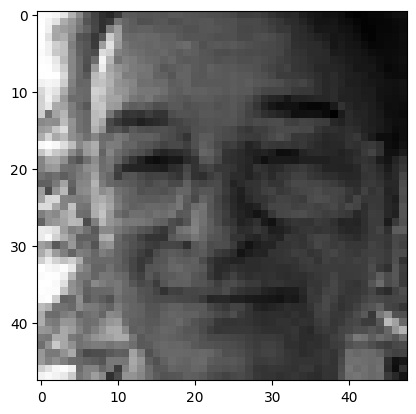

In [123]:
image = "images/train/happy/24.jpg"
print("original image of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ", pred_label)
plt.imshow(img.reshape(48,48),cmap ="gray")